In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [4]:
sns.set_style('whitegrid')

In [5]:
def format_time(t):
  """Return a formatted time string 'HH:MM:SS'
  based on a numeric time() value"""
  m, s = divmod(t, 60)
  h, m = divmod(m, 60)
  return f'{h:0>2.0f}:{m:0>2.2f}:{s:0>5.2f}'


# Get NASDAQ ITCH Data from FTP Server

In [6]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [7]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

In [9]:
def may_be_download(url):
  """Download & unzip ITCH data if not yet available"""
  if not data_path.exists():
    print('Creating directory')
    data_path.mkdir()
  else:
    print('Directory exists')
  
  filename = data_path / url.split('/')[-1]
  if not filename.exists():
    print('Downloading...', url)
    urlretrieve(url, filename)
  else:
    print('File exists')
  
  unzipped = data_path / (filename.stem + '.bin')
  if not unzipped.exists():
    print('Unzipping to', unzipped)
    with gzip.open(str(filename), 'rb') as f_in:
      with open(unzipped, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
  else:
    print('File already unpacked')
  
  return unzipped


In [10]:
file_name = may_be_download(urljoin(FTP_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Creating directory
Downloading... ftp://emi.nasdaq.com/ITCH/10302019.NASDAQ_ITCH50.gz
Unzipping to data/10302019.NASDAQ_ITCH50.bin


### Defining format strings

The parser uses format strings according to the following formats dictionaries:

In [11]:
event_codes = {'O' : 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [12]:
encoding = {'primary_market_maker' : {'Y': 1, 'N': 0},
            'printable'             : {'Y': 1, 'N': 0},
            'buy_sell_indicator'    : {'B': 1, 'S': -1},
            'cross_type'            : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction'   : {'B': 0, 'S': 1, 'N': 0, '0': -1}}

In [13]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s', # int of length 6 => parse as string, convert later

    ('integer', 8): 'Q',
    ('alpha', 1)  : 's',
    ('alpha', 2)  : '2s',
    ('alpha', 4)  : '4s',
    ('alpha', 8)  : '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

### Create message specs for binary data parser

In [14]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

In [15]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


In [17]:
def clean_message_types(df):
  df.columns = [c.lower().strip() for c in df.columns]
  df.value = df.value.str.strip()
  df.name = (df.name
             .str.strip() # remove whitespace
             .str.lower()
             .str.replace(' ', '_')
             .str.replace('-', '_')
             .str.replace('/', '_'))
  df.notes = df.notes.str.strip()
  df['message_type'] = df.loc[df.name == 'message_type', 'value']
  return df

In [18]:
message_types = clean_message_types(message_data)

### Get Message Labels
We extract message type codes and names so we can later make the results more readable.

In [19]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))

message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))

message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


### Finalize specification details

Each message consists of several fields that are defined by offset, length and type of value. The struct module will use this format information to parse the binary source data.

In [20]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))

message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


In [21]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [22]:
message_types.to_csv('message_types.csv', index=False)

In [23]:
message_types = pd.read_csv('message_types.csv')

The parser translates the message specs into format strings and namedtuples that capture the message content. First we create (type, length) formatting tuples from ITCH specs:

In [24]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                                   .apply(tuple, axis=1).map(formats))

Then, we extract formatting details for alphanumerical fields

In [25]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k,v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k,v in alpha_msgs.length}

We generate message classes as named tuples and format strings

In [26]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
  message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
  fstring[t] = '>' + ''.join(message.formats.tolist())

In [27]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [28]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


Fields of alpha type (alphanumeric) require post-processing as defined in the format_alpha function:

In [29]:
def format_alpha(mtype, data):
  """Process byte strings of type alpha"""

  for col in alpha_formats.get(mtype).keys():
    if mtype != 'R' and col == 'stock':
      data = data.drop(col, axis=1)
      continue
    data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
    if encoding.get(col):
      data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
  return data

## Process Binary Message Data
The binary file for a single day contains over 350,000,000 messages worth over 12 GB.

In [31]:
def store_messages(m):
  """Handle occasional storing of all messages"""
  with pd.HDFStore(itch_store) as store:
    for mtype, data in m.items():
      # convert to DataFrame
      data = pd.DataFrame(data)

      # parse timestamp info
      data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
      data.timestamp = pd.to_timedelta(data.timestamp)

      # apply alpha formatting
      if mtype in alpha_formats.keys():
        data = format_alpha(mtype, data)
      
      s = alpha_length.get(mtype)

      if s:
        s = {c: s.get(c) for c in data.columns}
      dc = ['stock_locate']
      if m == 'R':
        dc.append('stock')
      try:
        store.append(mtype,
                     data,
                     format='t',
                     min_itemsize=s,
                     data_columns=dc)
      except Exception as e:
        print(e)
        print(mtype)
        print(data.info())
        print(pd.Series(list(m.keys())).value_counts())
        data.to_csv('data.csv', index=False)
        return 1

  return 0

      

In [35]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

The following code processes the binary file and produces the parsed orders stored by message type:

In [36]:
start = time()

with file_name.open('rb') as data:
  while True:

    # determine message size in bytes
    message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

    # get message type by reading first byte
    message_type = data.read(1).decode('ascii')
    message_type_counter.update([message_type])

    # read & store message
    record = data.read(message_size - 1)
    message = message_fields[message_type]._make(unpack(fstring[message_type], record))
    messages[message_type].append(message)

    # deal with system events
    if message_type == 'S':
      seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
      print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
      if message.event_code.decode('ascii') == 'C':
        store_messages(messages)
        break
    message_count += 1

    if message_count % 2.5e7 == 0:
      seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
      d = format_time(time() - start)
      print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
      res = store_messages(messages)
      if res == 1:
        print(pd.Series(dict(message_type_counter)).sort_values())
        break
      messages.clear()
  
print('Duration:', format_time(time() - start))



 Start of Messages

 Start of System Hours

 Start of Market Hours
	09:44.00:09.23	  25,000,000	00:2.00:25.82
	10:7.00:45.15	  50,000,000	00:7.00:39.39
	10:39.00:56.24	  75,000,000	00:12.00:38.82
	11:18.00:09.64	 100,000,000	00:17.00:30.00
	11:58.00:35.35	 125,000,000	00:22.00:30.53
	12:44.00:20.61	 150,000,000	00:27.00:35.11
	13:41.00:03.75	 175,000,000	00:32.00:37.43
	14:18.00:44.52	 200,000,000	00:37.00:37.58
	14:49.00:19.38	 225,000,000	00:42.00:36.95
	15:19.00:40.72	 250,000,000	00:47.00:39.86
	15:50.00:23.01	 275,000,000	00:52.00:43.28

 End of Market Hours

 End of System Hours

 End of Messages
Duration: 00:59.00:25.65


## Summarize Trading Day

### Trading Message Frequency

In [37]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,127214649
D,order_delete,123296742
U,order_replace,25513651
E,order_executed,7316703
I,noii,3740140
X,order_cancel,3568735
P,trade,1525363
F,add_order_mpid_attribution,1423908
L,market_participant_position,214865
C,order_executed_with_price,129729


In [38]:
with pd.HDFStore(itch_store) as store:
  store.put('summary', counter)

### Top Equities by Traded Value

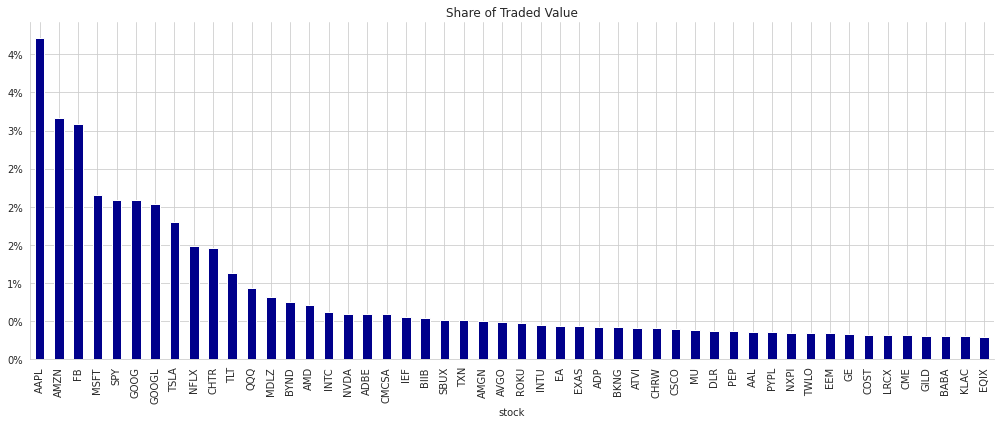

In [40]:
with pd.HDFStore(itch_store) as store:
  stocks = store['R'].loc[:, ['stock_locate', 'stock']]
  trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()

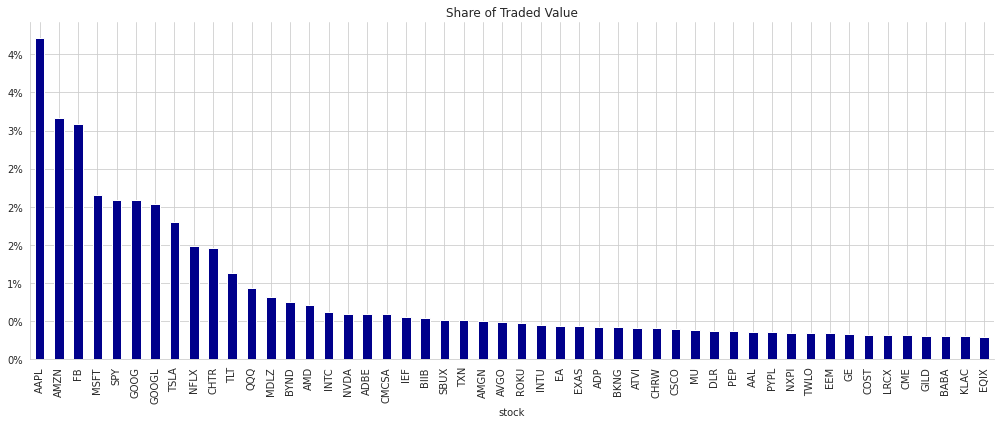

In [42]:
with pd.HDFStore(itch_store) as store:
  stocks = store['R'].loc[:, ['stock_locate', 'stock']]
  trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()